In [28]:
import math
import numpy as np

class TF_IDF():
    def __init__(self):
        self._doc_all = {}
        self._bow = []
        self._bow_idf = {}
    
    def bag_of_word(self, token_doclist):
        bag_words = list()
        for key in doc_all.keys():
            bag_words += doc_all[key]
        
        bag_words = set(bag_words)
        
        self._bow = bag_words
        return bag_words
    
    def tf(self, term, token_doc):
        tf = token_doc.count(term)/len(token_doc)
        return tf

    # create function to calculate how many doc contain the term 
    def numDocsContaining(self, word, token_doclist):
        doccount = 0
        for doc_token in token_doclist:
            if doc_token.count(word) > 0:
                doccount +=1
        return doccount
    
    # create function to calculate  Inverse Document Frequency in doclist - this list of all documents
    def idf(self, word, token_doclist):
        n = len(token_doclist)
        df = self.numDocsContaining(word, token_doclist)
        return math.log10(n/df)
    
    # calculate idf for every word in bag_words
    def bow_idf(self, token_doclist):
        bow = self.bag_of_word(token_doclist)
        
        bag_words_idf = dict()
        
        bag_words_len = len(bow)
        bag_word_10 = round(bag_words_len/10,0)
        print("the number of term in bag_word", bag_words_len)
        print("Start idf processing")
        
        i=0
        for word in bow:
            i+=1
            bag_words_idf[word] = self.idf(word, token_doclist)
            
            if (i%bag_word_10==0):
                print("finish %s idf processing" %(str(round(i*10/bag_word_10))+"%"))
            bag_words_idf[word]= self.idf(word,doc_all.values())
        
        print("finish idf processing")
        self._bow_idf = bag_words_idf
        return bag_words_idf

    # define a function to do cosine normalization a data dictionary
    def cos_norm(self, dic): # dic is distionary data structure
        dic_norm = {}
        factor = 1.0/np.sqrt(sum([np.square(i) for i in dic.values()]))
        for k in dic:
            dic_norm[k] = dic[k]*factor
        return dic_norm

    # create function to calculate normalize tfidf 
    def compute_tfidf(self, token_doc, bag_words_idf):
        tfidf_doc = {}
        for word in set(token_doc):
            tfidf_doc[word] = self.tf(word,token_doc) * bag_words_idf[word]   
        tfidf_norm = self.cos_norm(tfidf_doc)
        return tfidf_norm
    
    def tfidf(self, token_doclist, bag_words_idf):
        tfidf = {}
        
        for doc in doc_all.keys():
            tfidf[doc]= self.compute_tfidf(doc_all[doc], bag_words_idf)
        
        finish_time = datetime.now(timezone('Asia/Taipei')).strftime("%H:%M:%S")
        
        print("finish tfidf processing at", finish_time)
        return tfidf

    # create normalize term frequency
    def tf_norm(self, token_doc):
        tf_norm={}
        for term in token_doc:
            tf = token_doc.count(term)/len(token_doc)
            tf_norm[term] = tf
        tf_max = max(tf_norm.values())
        for term, value in tf_norm.items():
            tf_norm[term] = 0.5 + 0.5*value/tf_max
        return tf_norm

    def compute_tfidf_query(self, query_token, bag_words_idf):
        tfidf_query = {}
        tf_norm_query = self.tf_norm(query_token)
        for term, value in tf_norm_query.items():
            tfidf_query[term] = value * bag_words_idf[term]
        return tfidf_query

In [35]:
import os
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from datetime import datetime
from pytz import timezone
import pandas as pd
from scipy.spatial.distance import cosine
from wordcloud import WordCloud
import matplotlib.pyplot as plt

now = datetime.now(timezone('Asia/Taipei'))
nltk.download('punkt')


class QueryEngine(TF_IDF):
    def __init__(self):
        super().__init__()
        
        self.stopwords = self._load_stopwords()
        
    def _load_stopwords(self):
        sw = set(stopwords.words('english'))
        my_stopwords = [".", ",", "'ll", "'re", "'s", "!", "'ve", ",', ", "''", "``", "--", "n't", "?"]
        sw = list(sw) + my_stopwords
        return sw
    
    def tokenize(self, doc_list):
        doc_all = dict()
        
        for doc in doc_list:
            title = doc['title']
            tokens = nltk.word_tokenize(doc['description'])
            token_filtered = [w.lower() for w in tokens if w.isalpha()]
            doc_all[title] = token_filtered
            
        self._doc_all = doc_all
        return doc_all
    
    def text_preprocessing(self, doc_all, remove_stopwords=False, selective_POS=[]):
        if remove_stopwords == True:
            for key in doc_all.keys():
                doc_all[key] = [w for w in doc_all[key] if w not in self.stopwords]
                
        if selective_POS != []:
            for key in doc_all.keys():
                pos_tokens_list = nltk.pos_tag(doc_all[key])
                
                selective_pos_tkns = []
                for tkn in pos_tokens_list:
                    if tkn[1] in selective_POS:
                        selective_pos_tkns.append(tkn[0])

                doc_all[key] = selective_pos_tkns
        return doc_all
    
    def tfidf_query(self, doc_all, bow_idf, query, topK=10):
        query_token_raw = nltk.word_tokenize(query)
        query_token = [term for term in query_token_raw if term in self._bow]
        query_result = self.compute_tfidf_query(query_token, bow_idf) # calculate tfidf for query text
        
        # add tfidf of query text to tfidf of all doc and convert to dataframe
        tfidf = self.tfidf(doc_all, bow_idf)
        tfidf["query"] = query_result

        tfidf_df = pd.DataFrame(tfidf).transpose()
        tfidf_df= tfidf_df.fillna(0) # replace all NaN by zero
        
        cosine_sim = {}
        for row in tfidf_df.index:
            if row != "query":
                cosine_sim[row]= 1-cosine(tfidf_df.loc[row], tfidf_df.loc["query"])

        # the top k relevant document
        cosine_sim_topK = dict(sorted(cosine_sim.items(), key=lambda item: item[1], reverse=True)[:topK])
        
        return cosine_sim_topK
    
    def show_plot(self, query_result, isSave=False, file_name=''):
        data = query_result
        plt.barh(range(len(data)), list(data.values()), align='center', alpha=0.8)
        plt.yticks(range(len(data)), list(data.keys())) # label for y axis
        plt.xlabel('Smimilarity score')
        plt.ylabel('Course')

        # save graph
        if isSave:
            if not file_name:
                file_name = 'barchart'
            plt.savefig(file_name+".png", bbox_inches='tight', dpi=600)
            
        plt.show()
        
    def show_wordcloud(self, query_result, with_weight=False):
        wc = WordCloud(background_color="white", max_words=1000)
        
        
        query_bow = set()
        for title in query_result.keys():
            for w in self._doc_all[title]:
                if w in self._bow_idf.keys():
                    query_bow.add(w)
                
        query_bow_idf = {}
        for term in query_bow:
            query_bow_idf[term] = self._bow_idf[term]
        
        if with_weight:
            print(query_bow_idf)
        
        wc.generate_from_frequencies(query_bow_idf)
        plt.imshow(wc)
        plt.axis("off")
        plt.show()

[nltk_data] Downloading package punkt to /Users/jensonsu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Netflix Dataset

In [39]:
import csv

netflix_data = []
with open('netflix_titles.csv', newline='') as csvfile:
    rows = csv.reader(csvfile)
    
    for row in list(rows)[1:]:
        d = {
            'show_id': row[0],
            'type': row[1],
            'title': row[2],
            'director': row[3],
            'cast': row[4],
            'country': row[5],
            'date_added': row[6],
            'release_year': row[7],
            'rating': row[8],
            'duraiton': row[9],
            'listed_in': row[10],
            'description': row[11]
        }
        netflix_data.append(d)

In [40]:
qe = QueryEngine()

doc_all = qe.tokenize(netflix_data)

In [41]:
doc_all_feature = qe.text_preprocessing(doc_all, remove_stopwords=True, selective_POS=['NN','NNS', 'NNP', 'NNPS', 'JJ'])
bow_idf = qe.bow_idf(doc_all_feature.values())

the number of term in bag_word 12460
Start idf processing
finish 10% idf processing
finish 20% idf processing
finish 30% idf processing
finish 40% idf processing
finish 50% idf processing
finish 60% idf processing
finish 70% idf processing
finish 80% idf processing
finish 90% idf processing
finish 100% idf processing
finish idf processing


finish tfidf processing at 22:35:30
{'Scream 2': 0.2682125426102079, 'Jim Gaffigan: Cinco': 0.2673003143349242, 'To the Bone': 0.23190064579523262, 'Talking Tom and Friends': 0.22950415194690021, "Masha's Tales": 0.21952539768856616, 'The Honeymoon Stand Up Special': 0.20490563364318037, 'Jenny Slate: Stage Fright': 0.2022011592826909, 'A Scandall': 0.20190841207273735, 'Tarzan 2': 0.20117461839084883, 'A Russell Peters Christmas': 0.1986411649466343}


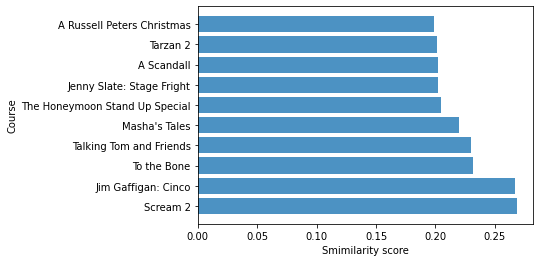

In [42]:
query = "funny and love movie"

tfidf_query_result = qe.tfidf_query(doc_all, bow_idf, query)
print(tfidf_query_result)

qe.show_plot(tfidf_query_result)

{'group': 1.5703178293510556, 'family': 1.1797657543012308, 'school': 1.4499818025509923, 'fairy': 2.7904259173911106, 'anorexia': 3.3133046626714484, 'animal': 2.246357873040835, 'cat': 2.4893959217271293, 'time': 1.7373474739076908, 'peters': 3.3133046626714484, 'throne': 3.012274667007467, 'catches': 3.3133046626714484, 'cohorts': 3.7904259173911106, 'relationships': 2.156957461811524, 'stories': 1.757002161904161, 'movie': 2.359062153232123, 'animated': 2.7490332322328856, 'deaths': 2.5351534122878046, 'mix': 2.836183407951786, 'graduate': 3.012274667007467, 'delivers': 2.5116723164382817, 'things': 2.034551061718619, 'nervosa': 3.7904259173911106, 'child': 2.050063227896867, 'twist': 2.7490332322328856, 'funny': 2.5116723164382817, 'journey': 1.9271030572706547, 'ready': 2.614334658335429, 'adventure': 1.9643511146902843, 'stage': 2.058032157568142, 'uncle': 2.6442978817128724, 'tales': 2.246357873040835, 'parenthood': 3.3133046626714484, 'jenny': 3.4893959217271293, 'mysterious':

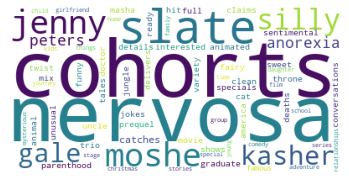

In [43]:
qe.show_wordcloud(tfidf_query_result, with_weight=True)